# NO_2 Retrieval from real TROPOMI data

## Rupesh Jeyaram -- ESE 156 Final Project

### Plan of Attack:

**Download TROPOMI Data**
- Solar Irradiance
- Observations (real data)

Solar Wavelength grid (x-axis, wl_solar): 497 points $\in$ [399.48962, 497.70505]

Solar Spectrum (y-axis, wl_spectrum): 497 points $\in$ [3.761847e-06, 8.576952e-06]


In [27]:
## Make sure plots are create inline
%matplotlib inline
## The usual packages (numpy, matplotlib, etc)
from RSE_style import *
from scipy.interpolate import interp1d
from scipy.ndimage.filters import gaussian_filter1d
import h5py as h5
import glob, os
from hapi import *

**Read in the solar irradiance from file:**

S5P_OFFL_L1B_IR_UVN_20181011T223825_20181012T001955_05158_01_010000_20181012T020852 2.h5

In [28]:
# Read in solar irradiance:
file_irrad = 'Data/S5P_OFFL_L1B_IR_UVN_20181011T223825_20181012T001955_05158_01_010000_20181012T020852 2.h5'
fI = h5.File(file_irrad)

**Extract Solar Irradiance Spectrum from data**

Using footprint 100

In [29]:
fp = 100
wl_solar = fI['BAND4_IRRADIANCE/STANDARD_MODE/INSTRUMENT/nominal_wavelength'][0,fp,:]
spec_solar = fI['BAND4_IRRADIANCE/STANDARD_MODE/OBSERVATIONS/irradiance'][0,0,fp,:]

In [30]:
print(fI['BAND4_IRRADIANCE/STANDARD_MODE/INSTRUMENT/nominal_wavelength'].shape)
print(fI['BAND4_IRRADIANCE/STANDARD_MODE/OBSERVATIONS/irradiance'])
#print(wl_solar)
# print(fI['BAND4_IRRADIANCE/STANDARD_MODE/OBSERVATIONS/irradiance'])
# print(min(wl_solar[100,]), max(wl_solar[100,]))
# print(min(spec_solar[100,]), max(spec_solar[100,])) 

(1, 450, 497)
<HDF5 dataset "irradiance": shape (1, 1, 450, 497), type "<f4">


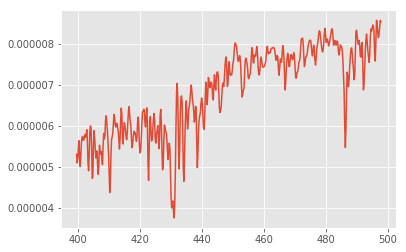

In [31]:
# Plot solar spectrum for specific footprint (imaging spectrometer!) 
plt.plot(wl_solar[:], spec_solar[:])

**Read from Instrument Data**

Plot spectrum obtained

In [32]:
# Read in real data:
file_nadir = 'Data/S5P_OFFL_L1B_RA_BD4_20181011T223825_20181012T001955_05158_01_010000_20181012T020852.zip'
fn = h5.File(file_nadir)


In [33]:
lat = fn['BAND4_RADIANCE/STANDARD_MODE/GEODATA/latitude'][0,:,:]
lon = fn['BAND4_RADIANCE/STANDARD_MODE/GEODATA/longitude'][0,:,:]
sza = fn['BAND4_RADIANCE/STANDARD_MODE/GEODATA/solar_zenith_angle'][0,:,:]
vza = fn['BAND4_RADIANCE/STANDARD_MODE/GEODATA/viewing_zenith_angle'][0,:,:]

In [100]:
# print(lat.shape)
# print(lon.shape)
# print(sza.shape)

# print fn()
# print(vza.shape)

# print(np.mean(sza))

print(np.min(sza))
print(np.min(lon))
print(np.min(lat))

14.611481
-179.9998
-89.97455


In [34]:
wl_spec = fn['BAND4_RADIANCE/STANDARD_MODE/INSTRUMENT/nominal_wavelength'][0,:,:]
spec = fn['BAND4_RADIANCE/STANDARD_MODE/OBSERVATIONS/radiance'][0,:,:,:]

In [35]:
print(fn['BAND4_RADIANCE/STANDARD_MODE/INSTRUMENT/nominal_wavelength'].shape)
print(fn['BAND4_RADIANCE/STANDARD_MODE/OBSERVATIONS/radiance'])

(1, 450, 497)
<HDF5 dataset "radiance": shape (1, 2906, 450, 497), type "<f4">


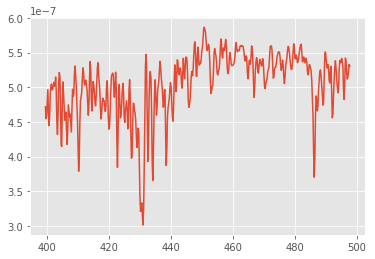

In [36]:
so = 1500
plt.plot(wl_spec[fp,:], spec[so,fp,:])

**Import Spline Functions**

Approximate solar spectrum using spline. 

Graph Reflectance = I / E_0 (instrument spectrum / solar irradiance). 

Compare approximation with actual. 

In [37]:
from scipy.interpolate import UnivariateSpline
spl = UnivariateSpline(wl_solar[:], spec_solar[:], k=3, s=0)

(405, 465)

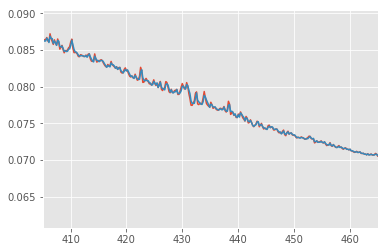

In [38]:
so = 1500
plt.plot(wl_spec[fp,:], spec[so,fp,:]/spl(wl_solar[:]+0.0))
plt.plot(wl_spec[fp,:], spec[so,fp,:]/spl(wl_spec[fp,:]-0.018))
plt.xlim((405,465))

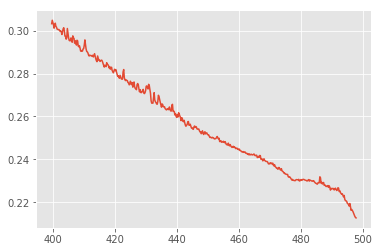

In [39]:
R_meas = np.pi * spec[so,fp,:] / (spl(wl_spec[fp,:]-0.018) * np.cos(np.deg2rad(sza[so,fp])))
# print(spec[so,fp,:].shape)

plt.plot(wl_spec[fp,:], R_meas)

**Obtain cross sections**

In [40]:
from urllib.request import urlopen
file_o3 = urlopen("ftp://fluo.gps.caltech.edu/XYZT_ESE156/TROPOMI/crossSections/O3_Serdyuchenko(2014)_243K_213-1100nm(2012 version).txt")
file_no2 = urlopen("ftp://fluo.gps.caltech.edu/XYZT_ESE156/TROPOMI/crossSections/NO2_Vandaele(1998)_220K_238-667nm.txt")
file_o4 = urlopen("ftp://fluo.gps.caltech.edu/XYZT_ESE156/TROPOMI/crossSections/O4_ThalmanVolkamer(2013)_293K_335.749-600.802nm.txt")


In [41]:
no2 = np.loadtxt(file_no2)
o4 = np.loadtxt(file_o4)
o3 = np.loadtxt(file_o3)
#h2o = np.loadtxt("H2O.data")

In [42]:
# plt.plot(no2)
print(o3.shape)
print(o4.shape)
#print(h2o.shape)
#print(h2o[:,0])

nu_, cs_h2o_1000hPa = absorptionCoefficient_Voigt(SourceTables='h2o', WavenumberRange=[1e7/500,1e7/350],Environment={'p':1,'T':293},WavenumberStep=0.01,WavenumberWing=40)

(88668, 2)
(4538, 2)
{'air': 1.0}


In [43]:
f = interp1d(1.e7/nu_, cs_h2o_1000hPa)
wl = np.arange(400,470,0.01)
cs_h2o = f(wl)
h2o = np.zeros((len(cs_h2o),2))
h2o[:,0]=wl
h2o[:,1]=cs_h2o

In [22]:
#os.chdir('/..')
#from hapi import *
#os.chdir('Data/')

In [23]:
# Get O2 cross sections between 1-3 wavenumbers.
import os, ssl
if (not os.environ.get('PYTHONHTTPSVERIFY', '') and
    getattr(ssl, '_create_unverified_context', None)): 
    ssl._create_default_https_context = ssl._create_unverified_context
fetch('h2o',1,1,1e7/500,1e7/350)


Data is fetched from http://hitran.org

BEGIN DOWNLOAD: h2o
  65536 bytes written to ./h2o.data
  65536 bytes written to ./h2o.data
  65536 bytes written to ./h2o.data
  65536 bytes written to ./h2o.data
  65536 bytes written to ./h2o.data
  65536 bytes written to ./h2o.data
  65536 bytes written to ./h2o.data
  65536 bytes written to ./h2o.data
Header written to ./h2o.header
END DOWNLOAD
                     Lines parsed: 3084
PROCESSED


In [23]:
# nu_, cs_h2o_1000hPa = absorptionCoefficient_Voigt(SourceTables='h2o', WavenumberRange=[1e7/500,1e7/350],Environment={'p':1,'T':293},WavenumberStep=0.01,WavenumberWing=40)

**Absorption Cross Spectra of NO2, O3, O4**

(0, 12)

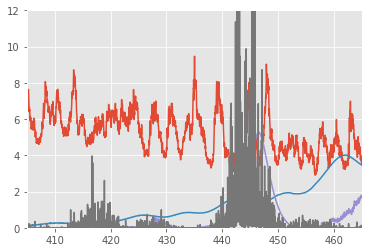

In [44]:
plt.plot(no2[:,0], no2[:,1]*1e19)
plt.plot(o3[:,0], o3[:,1]*1e22)
plt.plot(o4[:,0], o4[:,1]*1e47)
plt.plot(h2o[:,0],h2o[:,1]*1e26)
plt.xlim((405,465))
plt.ylim((0,12))

**Function for Convolving TROPOMI**

In [45]:
def convolveTROPOMI(cs, FWHM):
    wl = np.arange(400,470,0.01)
    f = interp1d(cs[:,0], cs[:,1])
    co = 2.355
    cs_conv =  gaussian_filter1d(f(wl), FWHM/0.01/co)
    return cs_conv

(0, 10)

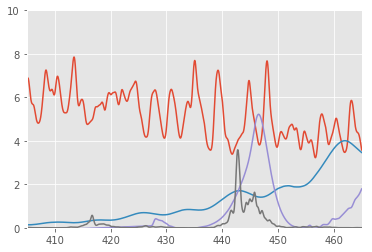

In [46]:
fwhm = 0.5
wl = np.arange(400,470,0.01)
plt.plot(wl, convolveTROPOMI(no2,fwhm)*1e19)
plt.plot(wl, convolveTROPOMI(o3,fwhm)*1e22)
plt.plot(wl, convolveTROPOMI(o4,fwhm)*1e47)
plt.plot(wl, convolveTROPOMI(h2o,fwhm)*1e26)
plt.xlim((405,465))
plt.ylim((0,10))

**Obtain ring spectrum**

(405, 465)

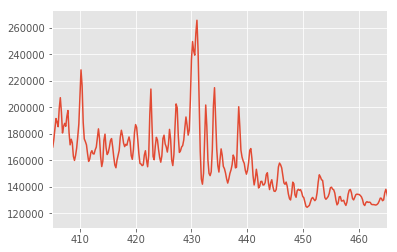

In [47]:
# Ring
plt.plot(wl_solar[:], 1/spec_solar[:])
plt.xlim((405,465))

**Obtain interpolations of convolutions**

In [48]:
wl_trop = wl_spec[fp,30:330]

fno2 = interp1d(wl, convolveTROPOMI(no2,fwhm))
fo3 = interp1d(wl, convolveTROPOMI(o3,fwhm))
fo4 = interp1d(wl, convolveTROPOMI(o4,fwhm))
fh2o = interp1d(wl, convolveTROPOMI(h2o,fwhm))

**Inversion Matrix K**

In [49]:
K = np.array(
    [-fno2(wl_trop),
     -fo3(wl_trop),
     -fo4(wl_trop), 
     -1/spec_solar[30:330], 
     -fh2o(wl_trop), 
     np.ones(len(wl_trop)), 
     (wl_trop-440), 
     (wl_trop-440)**2, 
     (wl_trop-440)**3]).T
gain = np.linalg.inv(K.T.dot(K)).dot(K.T)

**Perform Inversion**

In [50]:
so = 610
y = np.log(spec[so,fp,30:330]/spl(wl_solar[30:330]+0.01))
sv = gain.dot(y)

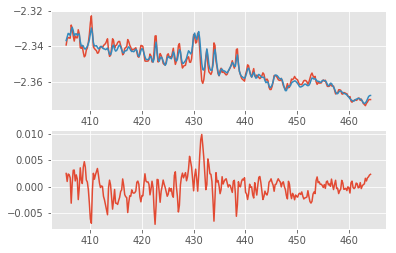

In [51]:
plt.subplot(211)
plt.plot(wl_trop, y,wl_trop, K.dot(sv) )
plt.subplot(212)
plt.plot(wl_trop, K.dot(sv)-y )

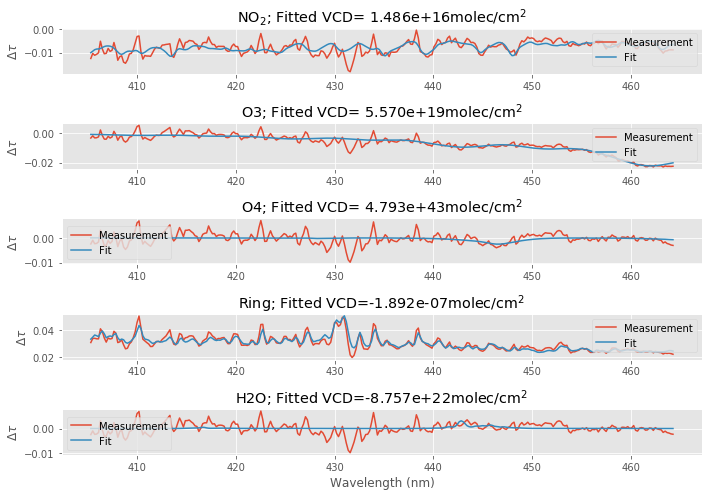

In [52]:
figsize(10,7)
leg = ['NO$_2$','O3','O4','Ring', 'H2O']

# Just use the Trace gases here, not the polynomial coefficients
for i in range(5):
    sv_copy = sv.copy()
    sv_copy[i]=0
    
    plt.subplot(5,1,i+1)
    plt.title(leg[i]+'; Fitted VCD='+ "%10.3e"% (sv[i])+ 'molec/cm$^2$')
    plt.plot(wl_trop, y-K.dot(sv_copy), wl_trop, K.dot(sv-sv_copy) )
    plt.ylabel(r'$\Delta \tau$')
    plt.legend(['Measurement','Fit'], loc=0)
plt.xlabel('Wavelength (nm)')
plt.tight_layout()

In [53]:
notro = np.zeros((2900,))
for i in range(2900):
    so = i
    y = np.log(spec[so,fp,30:330]/spl(wl_solar[30:330]-0.011))
    sv = gain.dot(y)
    notro[i]=sv[0]

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.


(400, 750)

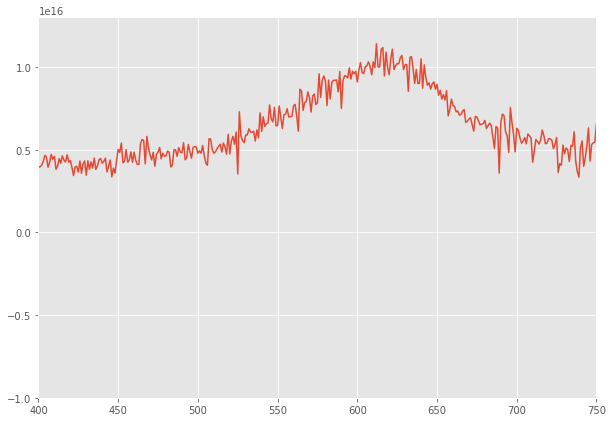

In [54]:
plt.plot(notro)
plt.ylim((-0.1e17,1.3e16))
plt.xlim((400,750))

**Okay cool, we're able to recover vertical column density at a location. Now let's do over the space:**

In [55]:
import matplotlib.pyplot as plt

# Stands for resolution multiplier
r_m = 2
coordinates = np.zeros((180 * r_m, 360 * r_m))

In [ ]:
for i in range(2906):
    if i%1000 == 0:
        print(i)
    #print('(' + str(lat[i, fp]) + ', ' + str(lon[i, fp]) + ')')
    for f in range(450):
        coordinates[int(((lat[so, f]) + 90) * r_m), int(((lon[so, f]) + 179) * r_m)] += 1000
    
    
    
#     no2s[int(round(lat[i, fp+50]) + 90), int(round(lon[i, fp+50]) + 179)] = 0.75
#     no2s[int(round(lat[i, fp+100]) + 90), int(round(lon[i, fp+100]) + 179)] = 0.5

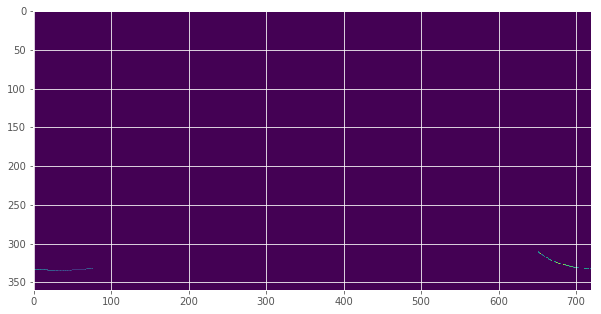

In [34]:
plt.imshow(coordinates)

In [56]:
r_m = 2
sza_thresh = 75;
no2s = np.zeros((180 * r_m, 360 * r_m))
counts = np.zeros((180 * r_m, 360 * r_m))

wl_solar = fI['BAND4_IRRADIANCE/STANDARD_MODE/INSTRUMENT/nominal_wavelength'][0,:,:]
spec_solar = fI['BAND4_IRRADIANCE/STANDARD_MODE/OBSERVATIONS/irradiance'][0,0,:,:]

i = -1
for fp in range(450):
    if fp%100 == 0:
        print(fp)
    
    wl_trop = wl_spec[fp,30:330]
    # Include H2O back in HERE
    K = np.array(
        [-fno2(wl_trop),
         -fo3(wl_trop),
         -fo4(wl_trop), 
         -1/spec_solar[fp, 30:330], 
         -fh2o(wl_trop), 
         np.ones(len(wl_trop)), 
         (wl_trop-440), 
         (wl_trop-440)**2, 
         (wl_trop-440)**3]).T
    gain = np.linalg.inv(K.T.dot(K)).dot(K.T)
    
    for so in range(2900):
        if sza[so,fp] < sza_thresh:
            
            y = np.log(spec[so,fp,30:330]/spl(wl_solar[fp, 30:330]+0.01))
            sv = gain.dot(y)
            no2s[int(((lat[so, fp]) + 90) * r_m), int(((lon[so, fp]) + 179) * r_m)] += sv[0]
            counts[int(((lat[so, fp]) + 90) * r_m), int(((lon[so, fp]) + 179) * r_m)] += 1


0
100
200
300
400


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


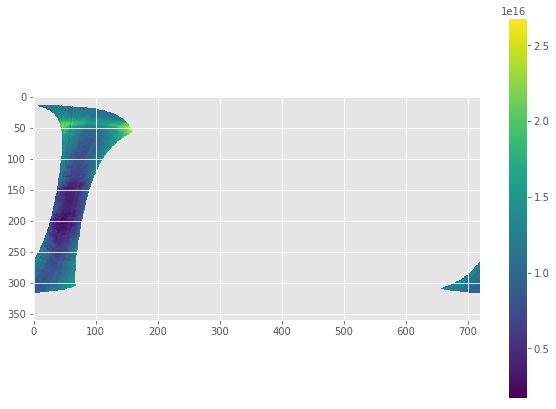

In [57]:
plt.imshow(np.divide(no2s, counts))
plt.colorbar()

**Cool, lets go over all the files now and obtain full retrieval around the globe**

1 Data/S5P_OFFL_L1B_RA_BD4_20181012T020124_20181012T034254_05160_01_010000_20181012T052914.zip
0
100
200
300
400
2 Data/S5P_OFFL_L1B_RA_BD4_20181012T001955_20181012T020124_05159_01_010000_20181012T034905.zip
0
100
200
300
400
3 Data/S5P_OFFL_L1B_RA_BD4_20181011T223825_20181012T001955_05158_01_010000_20181012T020852.zip
0
100
200
300
400
4 Data/S5P_OFFL_L1B_RA_BD4_20181012T171449_20181012T185618_05169_01_010000_20181012T204117.zip
0
100
200
300
400


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


5 Data/S5P_OFFL_L1B_RA_BD4_20181012T052423_20181012T070552_05162_01_010000_20181012T084939.zip
0
100
200
300
400
6 Data/S5P_OFFL_L1B_RA_BD4_20181011T205656_20181011T223825_05157_01_010000_20181012T002841.zip
0
100
200
300
400
7 Data/S5P_OFFL_L1B_RA_BD4_20181012T102851_20181012T121021_05165_01_010000_20181012T140022.zip
0
100
200
300
400
8 Data/S5P_OFFL_L1B_RA_BD4_20181012T135150_20181012T153319_05167_01_010000_20181012T172047.zip
0
100
200
300
400
9 Data/S5P_OFFL_L1B_RA_BD4_20181012T034254_20181012T052423_05161_01_010000_20181012T070926.zip
0
100
200
300
400
10 Data/S5P_OFFL_L1B_RA_BD4_20181011T191527_20181011T205656_05156_01_010000_20181011T223836.zip
0
100
200
300
400
11 Data/S5P_OFFL_L1B_RA_BD4_20181012T084722_20181012T102851_05164_01_010000_20181012T121005.zip
0
100
200
300
400
12 Data/S5P_OFFL_L1B_RA_BD4_20181012T121021_20181012T135150_05166_01_010000_20181012T154030.zip
0
100
200
300
400
13 Data/S5P_OFFL_L1B_RA_BD4_20181012T153319_20181012T171449_05168_01_010000_20181012T190103.z

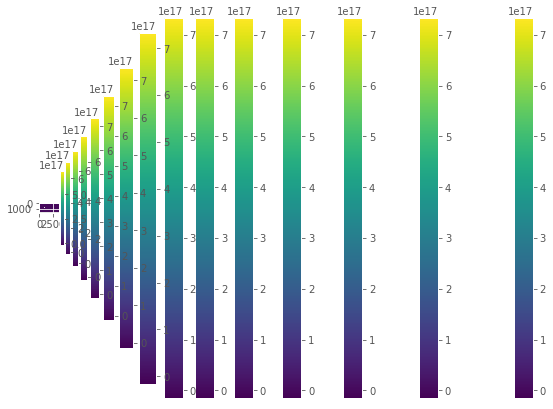

In [131]:
i = 1

r_m = 10
sza_thresh = 85;
no2s = np.zeros((180 * r_m, 360 * r_m))
counts = np.zeros((180 * r_m, 360 * r_m))

wl_solar = fI['BAND4_IRRADIANCE/STANDARD_MODE/INSTRUMENT/nominal_wavelength'][0,:,:]
spec_solar = fI['BAND4_IRRADIANCE/STANDARD_MODE/OBSERVATIONS/irradiance'][0,0,:,:]

for file in glob.glob("Data/*.zip"):
    
    if i % 5 == 0:
        plt.imshow(np.divide(no2s, counts))
        plt.colorbar()
    
    # Read in real data:
    file_nadir = file
    fn = h5.File(file_nadir)
    
#     for j in (fn.keys()):
#         print(j)
    
    if ('BAND4_RADIANCE' in fn.keys()):
        print(i, file)
        # Load Geo Data
        lat = fn['BAND4_RADIANCE/STANDARD_MODE/GEODATA/latitude'][0,:,:]
        lon = fn['BAND4_RADIANCE/STANDARD_MODE/GEODATA/longitude'][0,:,:]
        sza = fn['BAND4_RADIANCE/STANDARD_MODE/GEODATA/solar_zenith_angle'][0,:,:]

        wl_spec = fn['BAND4_RADIANCE/STANDARD_MODE/INSTRUMENT/nominal_wavelength'][0,:,:]
        spec = fn['BAND4_RADIANCE/STANDARD_MODE/OBSERVATIONS/radiance'][0,:,:,:]
    
#     elif ('BAND5_RADIANCE' in fn.keys()):
        
#         print(i, file)
#         # Load Geo Data
#         lat = fn['BAND5_RADIANCE/STANDARD_MODE/GEODATA/latitude'][0,:,:]
#         lon = fn['BAND5_RADIANCE/STANDARD_MODE/GEODATA/longitude'][0,:,:]
#         sza = fn['BAND5_RADIANCE/STANDARD_MODE/GEODATA/solar_zenith_angle'][0,:,:]

#         wl_spec = fn['BAND5_RADIANCE/STANDARD_MODE/INSTRUMENT/nominal_wavelength'][0,:,:]
#         spec = fn['BAND5_RADIANCE/STANDARD_MODE/OBSERVATIONS/radiance'][0,:,:,:]
        
#         print(wl_spec.shape)
#         print(spec.shape)
    
#     elif ('BAND6_RADIANCE' in fn.keys()):
    
#         print(i, file)
#         # Load Geo Data
#         lat = fn['BAND6_RADIANCE/STANDARD_MODE/GEODATA/latitude'][0,:,:]
#         lon = fn['BAND6_RADIANCE/STANDARD_MODE/GEODATA/longitude'][0,:,:]
#         sza = fn['BAND6_RADIANCE/STANDARD_MODE/GEODATA/solar_zenith_angle'][0,:,:]

#         wl_spec = fn['BAND6_RADIANCE/STANDARD_MODE/INSTRUMENT/nominal_wavelength'][0,:,:]
#         spec = fn['BAND6_RADIANCE/STANDARD_MODE/OBSERVATIONS/radiance'][0,:,:,:]
        
    else: 
        continue
        
    for fp in range(450):

        if fp % 100 == 0:
            print(fp)

        wl_trop = wl_spec[fp,30:330]

        # Include H2O back in HERE
        K = np.array(
            [-fno2(wl_trop),
             -fo3(wl_trop),
             -fo4(wl_trop), 
             -1/spec_solar[fp, 30:330], 
             -fh2o(wl_trop), 
              np.ones(len(wl_trop)), 
             (wl_trop-440), 
             (wl_trop-440)**2, 
             (wl_trop-440)**3]).T
        gain = np.linalg.inv(K.T.dot(K)).dot(K.T)

        for so in range(2900):
            if sza[so,fp] < sza_thresh:
                AMF = (1./np.cos(np.deg2rad(sza[so,fp])) + 1./np.cos(np.deg2rad(vza[so,fp])))
                y = np.log( (spec[so,fp,30:330]/spl(wl_solar[fp, 30:330]+0.01)) / AMF)
                sv = gain.dot(y)
                no2s[int(((lat[so, fp]) + 90) * r_m), int(((lon[so, fp]) + 179) * r_m)] += sv[0]/AMF
                counts[int(((lat[so, fp]) + 90) * r_m), int(((lon[so, fp]) + 179) * r_m)] += 1
                    
    i = i + 1

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


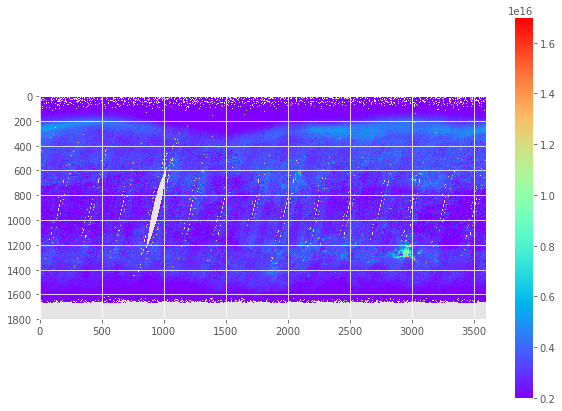

In [132]:
plt.imshow((np.divide(no2s, counts)), cmap = plt.get_cmap('rainbow'))
plt.colorbar()
plt.clim(0.2e16, 1.7e16);
# np.max(np.where(no2s < 1e17))

7154998290560999.0


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


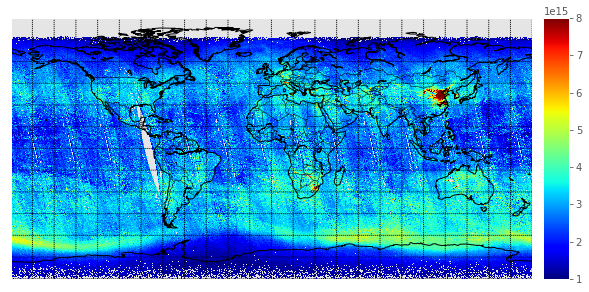

In [143]:
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.basemap import Basemap

print(np.nanmean(no2s))

# map = Basemap(projection='cyl', lat_0 = 90, lon_0 = -180, resolution = 'c', area_thresh = 0.1, llcrnrlon=0.0, llcrnrlat=-60.0, urcrnrlon=360.0, urcrnrlat=60.0)
map = Basemap(projection='cyl',llcrnrlat=-90,urcrnrlat=90, llcrnrlon=-180,urcrnrlon=180,resolution='c')
map.drawcoastlines()
map.drawcountries()
map.drawparallels(np.arange(-90,90,15.0))
map.drawmeridians(np.arange(-180,180,15))

map.imshow((np.divide(no2s, counts)), cmap = plt.get_cmap('jet'), clim = (10e14, 8e15))

map.colorbar()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


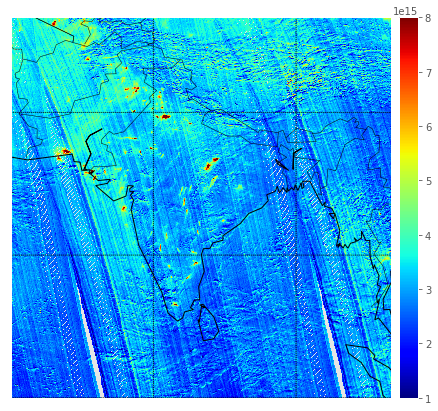

In [171]:
np.zeros((180 * r_m, 360 * r_m))

# map = Basemap(projection='cyl', lat_0 = 90, lon_0 = -180, resolution = 'c', area_thresh = 0.1, llcrnrlon=0.0, llcrnrlat=-60.0, urcrnrlon=360.0, urcrnrlat=60.0)
map = Basemap(projection='cyl',llcrnrlat=0,urcrnrlat=40, llcrnrlon=60,urcrnrlon=100,resolution='c')
map.drawcoastlines()
map.drawcountries()
map.drawparallels(np.arange(-90,90,15.0))
map.drawmeridians(np.arange(-180,180,15))

map.imshow((np.divide(no2s, counts))[(90-1) * r_m:(90+40-1) * r_m, (60 + 180) * r_m:(100 + 180) * r_m], cmap = plt.get_cmap('jet'), clim = (10e14, 8e15))

map.colorbar()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


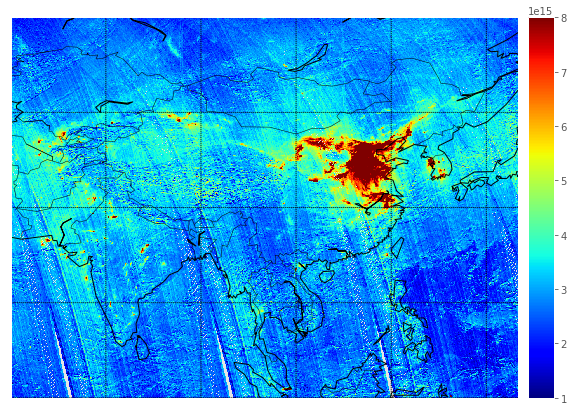

In [168]:
np.zeros((180 * r_m, 360 * r_m))

# map = Basemap(projection='cyl', lat_0 = 90, lon_0 = -180, resolution = 'c', area_thresh = 0.1, llcrnrlon=0.0, llcrnrlat=-60.0, urcrnrlon=360.0, urcrnrlat=60.0)
map = Basemap(projection='cyl',llcrnrlat=0,urcrnrlat=60, llcrnrlon=60,urcrnrlon=140,resolution='c')
map.drawcoastlines()
map.drawcountries()
map.drawparallels(np.arange(-90,90,15.0))
map.drawmeridians(np.arange(-180,180,15))

map.imshow((np.divide(no2s, counts))[(90-1) * r_m:(90+60-1) * r_m, (60 + 180) * r_m:(140 + 180) * r_m], cmap = plt.get_cmap('jet'), clim = (10e14, 8e15))

map.colorbar()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


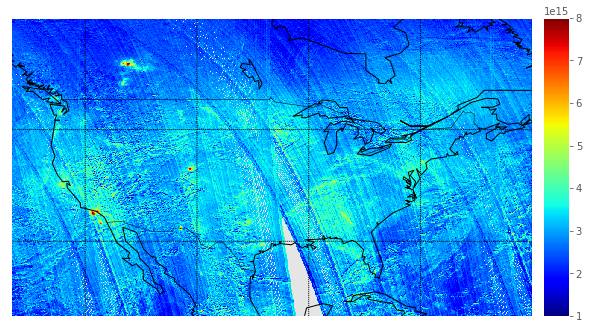

In [181]:
np.zeros((180 * r_m, 360 * r_m))

# map = Basemap(projection='cyl', lat_0 = 90, lon_0 = -180, resolution = 'c', area_thresh = 0.1, llcrnrlon=0.0, llcrnrlat=-60.0, urcrnrlon=360.0, urcrnrlat=60.0)
map = Basemap(projection='cyl',llcrnrlat=20,urcrnrlat=60, llcrnrlon=-130,urcrnrlon=-60,resolution='c')
map.drawcoastlines()
map.drawcountries()
map.drawparallels(np.arange(-90,90,15.0))
map.drawmeridians(np.arange(-180,180,15))

map.imshow((np.divide(no2s, counts))[(90+20) * r_m:(90+60) * r_m, (-130 + 180) * r_m:(-60 + 180) * r_m], cmap = plt.get_cmap('jet'), clim = (10e14, 8e15))

map.colorbar()